# Exercise 8: Anomaly Detection and Collaborative Filtering

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.optimize import fmin_cg
import warnings; warnings.filterwarnings('ignore')

## ===============
## Anomaly Detection
## ===============
### Part 1: Load Example Dataset

In [2]:
data = sio.loadmat('ex8data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [3]:
X, Xval, yval = data['X'], data['Xval'], data['yval']
X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

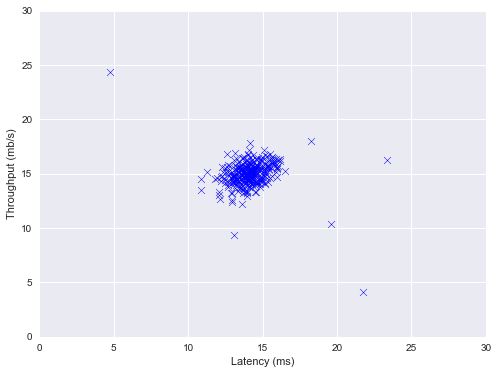

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], marker='x', c='b', linewidth=.5)
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

### Part 2: Estimate The Dataset Statistics

In [5]:
def estimateGaussian(X):
    '''This function estimates the parameters of a 
       Gaussian distribution using the data in X'''
    mu, sigma2 = np.mean(X, axis=0), np.var(X, axis=0)
    return mu.reshape(1, len(mu)), sigma2.reshape(1, len(sigma2))

def multivariateGaussian(X, mu, sigma2):
    '''Computes the probability density function of the
       multivariate gaussian distribution.'''
    k = len(mu.ravel())
    if 1 in sigma2.shape:
        sigma2 = np.diag(sigma2.ravel())

    X1 = X - mu
    p = (2 * np.pi)**(-k / 2) * np.linalg.det(sigma2)**(-.5) *\
        np.e**(-.5 * (X1 @ np.linalg.pinv(sigma2) * X1).sum(axis=1))
    return p

def selectThreshold(yval, pval):
    '''Find the best threshold (epsilon) to use for selecting outliers'''
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    stepsize = (np.max(pval) - np.min(pval)) / 1000

    for epsilon in np.arange(np.min(pval), np.max(pval) + stepsize, stepsize):
        pred = (pval < epsilon)
        x = np.c_[yval, pred]
        
        tp = ((x[:, 0] == 1) & (x[:, 1] == 1)).sum()
        tn = ((x[:, 0] == 0) & (x[:, 1] == 0)).sum()
        fp = ((x[:, 0] == 0) & (x[:, 1] == 1)).sum()
        fn = ((x[:, 0] == 1) & (x[:, 1] == 0)).sum()
        
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        
        F1 = 2 * recall * precision / (recall + precision)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    return bestEpsilon, bestF1

def visualizeFit(X, mu, sigma2):
    '''Visualize the dataset and its estimated distribution.'''
    X1, X2 = np.meshgrid(np.arange(0, 35.5, .5), np.arange(0, 35.5, .5))
    Z = multivariateGaussian(np.c_[X1.ravel(), X2.ravel()], mu, sigma2)
    Z = Z.reshape(X1.shape)
    
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], marker='x', c='b', linewidth=.5)
    if np.isinf(Z).sum() == 0:
        plt.contour(X1, X2, Z, levels=(.1**np.arange(20, 0, -3)).T, linewidths=1)

In [6]:
mu, sigma2 = estimateGaussian(X)

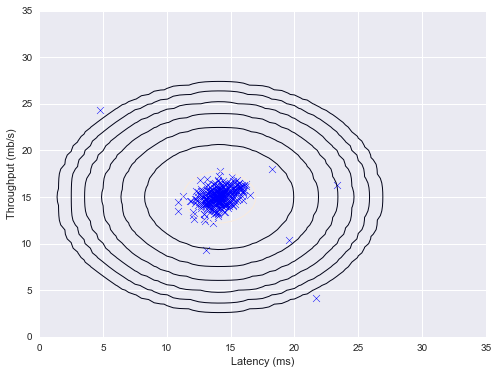

In [7]:
visualizeFit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

### Part 3: Find Outliers

In [8]:
p_val = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, p_val)

print('Best epsilon found using cross-validation:\n', epsilon)
print('Best F1 on Cross Validation set:\n', F1)

Best epsilon found using cross-validation:
 8.990852779269495e-05
Best F1 on Cross Validation set:
 0.8750000000000001


In [9]:
p = multivariateGaussian(X, mu, sigma2)
outliers = X[np.argwhere(p < epsilon)]
print(outliers.shape)
print(outliers[0])

(6, 1, 2)
[[13.07931049  9.34787812]]


In [10]:
outliers = outliers.reshape(6, 2)

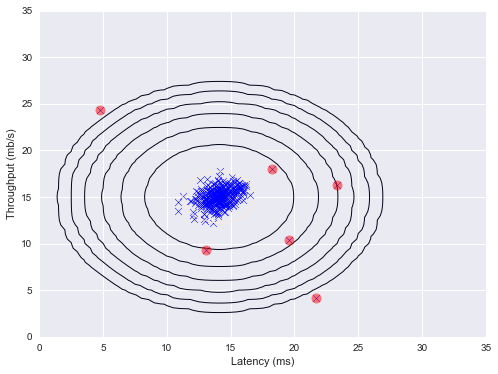

In [11]:
visualizeFit(X, mu, sigma2)
plt.plot(outliers[:, 0], outliers[:, 1], 'ro', markersize=10, alpha=.5)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

### Part 4: Multidimensional Outliers

In [12]:
data = sio.loadmat('ex8data2.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [13]:
X, Xval, yval = data['X'], data['Xval'], data['yval']
X.shape, Xval.shape, yval.shape

((1000, 11), (100, 11), (100, 1))

In [14]:
mu, sigma2 = estimateGaussian(X)
p = multivariateGaussian(X, mu, sigma2)
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)
outliers = X[np.argwhere(p < epsilon)]
print(outliers.shape)
print(outliers[0])

(117, 1, 11)
[[ 15.1078769  -16.43076621  19.70736028 -19.81188774  -1.64453684
   -6.4441843   -6.1212137    7.04228272   7.2324756   17.22347919
   -2.95685157]]


In [15]:
outliers = outliers.reshape(117, 11)

print('Best epsilon found using cross-validation:\n', epsilon)
print('\nBest F1 on Cross Validation Set:\n', F1)
print('\n# Outliers found: \n', len(outliers))

Best epsilon found using cross-validation:
 1.3772288907613581e-18

Best F1 on Cross Validation Set:
 0.6153846153846154

# Outliers found: 
 117


## ===================
## Recommender Systems
## ===================
### Part 1: Loading Movie Ratings Dataset

In [16]:
data = sio.loadmat('ex8_movies.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [17]:
Y, R = data['Y'], data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

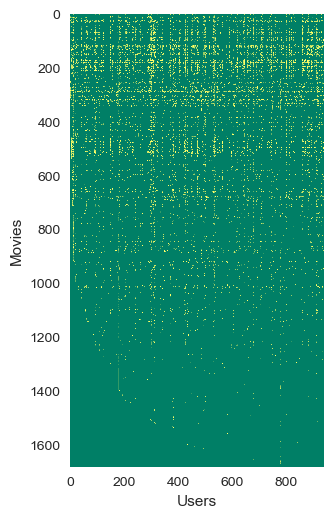

In [18]:
plt.figure(dpi=100)
plt.imshow(Y, cmap='summer')
plt.grid()
plt.xlabel('Users')
plt.ylabel('Movies')
plt.show()

### Part 2: Collaborative Filtering Cost Function

In [19]:
data = sio.loadmat('ex8_movieParams.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [20]:
X, Theta, num_users, num_movies, num_features = [data[i] for i in list(data.keys())[3:]]
X.shape, Theta.shape, num_users.shape, num_movies.shape, num_features.shape

((1682, 10), (943, 10), (1, 1), (1, 1), (1, 1))

In [21]:
num_users, num_movies, num_features = 4, 5, 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [22]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lmd):
    '''Collaborative filtering cost function'''
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    J = ((R * (X @ Theta.T - Y))**2).sum() / 2 + lmd / 2 * ((Theta**2).sum() + (X**2).sum())
    
    X_grad = R * (X @ Theta.T - Y) @ Theta + lmd * X
    Theta_grad = (R * (X @ Theta.T - Y)).T @ X + lmd * Theta
    grad = np.vstack((X_grad.reshape(-1, 1), Theta_grad.reshape(-1, 1)))
    return J, grad

In [23]:
X_grad = R * (X @ Theta.T - Y) @ Theta 
Theta_grad = (R * (X @ Theta.T - Y)).T @ X

In [24]:
J = cofiCostFunc(np.vstack((X.reshape(-1, 1), Theta.reshape(-1, 1))), 
                 Y, R, num_users, num_movies, num_features, 0)[0]

print('Cost at loaded parameters: ', J)

Cost at loaded parameters:  22.224603725685675


### Part 3: Collaborative Filtering Gradient

In [25]:
def computeNumericalGradient(J, theta):
    '''Computes the gradient using "finite differences" 
       and gives us a numerical estimate of the gradient.'''
    numgrad = np.zeros_like(theta)
    perturb = np.zeros_like(theta)
    
    e = 1e-4
    for p in range(len(theta.flatten())):
        perturb[p] = e
        loss1 = J(theta - perturb)[0]
        loss2 = J(theta + perturb)[0]
        numgrad[p] = (loss2 - loss1) / 2 / e
        perturb[p] = 0
    return numgrad
    
def checkCostFunction(lmd=0):
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)
    
    Y = X_t @ Theta_t.T
    Y[np.random.rand(Y.shape[0], Y.shape[1]) > .5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1
    
    X = np.random.randn(X_t.shape[0], X_t.shape[1])
    Theta = np.random.randn(Theta_t.shape[0], Theta_t.shape[1])
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]
    
    def costFunc(t):
        return cofiCostFunc(t, Y, R, num_users, num_movies, num_features, lmd)
    
    numgrad = computeNumericalGradient(costFunc, 
                                       np.vstack((X.reshape(-1, 1), Theta.reshape(-1, 1))))
    cost, grad = cofiCostFunc((np.vstack((X.reshape(-1, 1), Theta.reshape(-1, 1)))), Y, R,
                              num_users, num_movies, num_features, lmd)
    for i, j in zip(numgrad, grad):
        if 10 > i >= 0:
            print(' {0:.10f}'.format(i[0]), '   ', ' {0:.10f}'.format(j[0]))
        elif i > 10:
            print(' {0:.9f}'.format(i[0]), '   ', ' {0:.9f}'.format(j[0]))
        elif i < -10:
            print('{0:.9f}'.format(i[0]), '   ', '{0:.9f}'.format(j[0]))
        else:
            print('{0:.10f}     {0:.10f}'.format(i[0], j[0]))
            
    print('\nThe above two columns you get should be very similar.\n',
         '(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n')
    
    diff = np.max(numgrad - grad) / np.max(numgrad + grad)
    
    print('If your backpropagation implementation is correct, then\n',
         'the relative difference will be small (less than 1e-9).\n',
         '\nRelative Difference: ', diff)
    
    try:
        np.testing.assert_almost_equal(numgrad, grad)
        print('\n\nTwo results are almost the same. Assertion passed!')
    except:
        print('\n\nTwo results are greatly differenct. Check cost function!')

In [26]:
checkCostFunction()

 1.6396424111      1.6396424111
-15.878669445     -15.878669445
-10.255942251     -10.255942251
 3.0400900488      3.0400900488
 22.308007275      22.308007275
 11.499255973      11.499255973
 0.9550240797      0.9550240798
 1.0550124186      1.0550124186
-0.3420162558     -0.3420162558
 6.8288433737      6.8288433737
 8.5442841415      8.5442841415
 0.3045860241      0.3045860241
-0.2683729179     -0.2683729179
-1.4143403473     -1.4143403473
 0.5439300237      0.5439300237
 0.5522386493      0.5522386492
-4.1790657399     -4.1790657399
-1.2960744456     -1.2960744456
 0.7538295462      0.7538295463
-11.514957775     -11.514957775
-16.550945778     -16.550945778
-0.2284109146     -0.2284109146
-1.2106503640     -1.2106503640
-0.6122624394     -0.6122624394
 0.2074534084      0.2074534084
-7.4745468724     -7.4745468724
-1.2524533807     -1.2524533807

The above two columns you get should be very similar.
 (Left-Your Numerical Gradient, Right-Analytical Gradient)


If your backpropagat

### Part 4: Collaborative Filtering Cost Regularization

In [27]:
J = cofiCostFunc(np.vstack((X.reshape(-1, 1), Theta.reshape(-1, 1))),
                Y, R, num_users, num_movies, num_features, 1.5)

print('Cost at loaded parameters (lambda=1.5): ', J[0])

Cost at loaded parameters (lambda=1.5):  31.34405624427422


### Part 5: Collaborative Filtering Gradient Regularization

In [28]:
checkCostFunction(1.5)

-1.4680211941     -1.4680211941
 0.7468457434      0.7468457434
 2.9575988666      2.9575988666
 6.2193140439      6.2193140438
-1.8104990223     -1.8104990223
 3.7465346239      3.7465346239
-2.4722806187     -2.4722806187
 0.2517979161      0.2517979161
-8.4528356382     -8.4528356382
-2.3138193144     -2.3138193144
 0.7131804409      0.7131804409
 0.8791010689      0.8791010689
 1.3573509807      1.3573509807
-0.7892142005     -0.7892142005
 1.0732917733      1.0732917733
 6.6112093271      6.6112093271
 0.8827974070      0.8827974070
 7.2088378390      7.2088378390
 0.8836996416      0.8836996416
 0.4016069342      0.4016069342
 1.6761531364      1.6761531364
 3.2647742329      3.2647742329
-2.2007963379     -2.2007963379
-5.2084397587     -5.2084397587
 3.2421723841      3.2421723841
 1.0836184872      1.0836184872
 3.6654663163      3.6654663163

The above two columns you get should be very similar.
 (Left-Your Numerical Gradient, Right-Analytical Gradient)


If your backpropagat

### Part 6: Entering Ratings for A New User

In [29]:
def loadMovieList():
    '''Reads the fixed movie list in movie.txt and returns a dict of the words'''
    import re
    
    movieList = {}
    with open('movie_ids.txt', 'rb') as f:
        data = f.read().decode('ascii', 'ignore')
    data = re.findall('[0-9]* (.*?)\n', data)
    for i in range(len(data)):
        movieList[i] = data[i]
    return movieList

In [30]:
movieList = loadMovieList()
my_ratings = np.zeros((1682, 1))
my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [31]:
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated {} for {}'.format(my_ratings[i][0], movieList[i]))

Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for Silence of the Lambs, The (1991)
Rated 4.0 for Alien (1979)
Rated 5.0 for Die Hard 2 (1990)
Rated 5.0 for Sphere (1998)


### Part 7: Learning Movie Ratings

In [32]:
data = sio.loadmat('ex8_movies.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [33]:
Y, R = data['Y'], data['R']
Y = np.c_[my_ratings, Y]
R = np.c_[my_ratings, R]

In [34]:
def normolizeRatings(Y, R):
    '''Preprocess data by subtracting mean rating for every movie (every row)'''
    m, n = Y.shape
    Ymean = np.zeros((m, 1))
    Ynorm = np.zeros(Y.shape)
    for i in range(m):
        idx = np.argwhere(R[i, :] == 1)
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] -Ymean[i]
    return Ynorm, Ymean
    

In [35]:
Ynorm, Ymean = normolizeRatings(Y, R)
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_parameters = np.vstack((X.reshape(-1, 1), Theta.reshape(-1, 1))).flatten()
lmd = 10

In [36]:
def costFunc(t):
    '''To be called by optimization function fmin_cg for model training'''
    return cofiCostFunc(t, Ynorm, R, num_users, num_movies, num_features, lmd)[0]
def gradientFunc(t):
    '''To be called by optimization function fmin_cg for model training'''
    return cofiCostFunc(t, Ynorm, R, num_users, num_movies, num_features, lmd)[1].ravel()

In [37]:
theta = fmin_cg(costFunc, initial_parameters, gradientFunc, maxiter=100)

         Current function value: 38952.520459
         Iterations: 100
         Function evaluations: 146
         Gradient evaluations: 146


In [38]:
X = theta[:num_movies * num_features].reshape(num_movies, num_features)
Theta = theta[num_movies * num_features:].reshape(num_users, num_features)

print('\nRecommender system learning completed!\n\n')


Recommender system learning completed!




### Part 8: Recommendation for you

In [39]:
p = X @ Theta.T
my_predictions = p[:, 0].reshape(-1, 1) + Ymean
movieList = loadMovieList()

r = np.sort(my_predictions, axis=None)
idx = np.argsort(my_predictions, axis=None)[::-1]

print('Top recommendations for you:\n')
for i in range(10):
    print('Predicting rating {} for movie {}'.format(int(my_predictions[idx[i]][0]), 
                                                     movieList[idx[i]]))

print('\nOriginal ratings provided:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated {} for {}'.format(my_ratings[i][0], movieList[i]))

Top recommendations for you:

Predicting rating 5 for movie Santa with Muscles (1996)
Predicting rating 5 for movie Marlene Dietrich: Shadow and Light (1996) 
Predicting rating 5 for movie Star Kid (1997)
Predicting rating 4 for movie Prefontaine (1997)
Predicting rating 4 for movie They Made Me a Criminal (1939)
Predicting rating 4 for movie Aiqing wansui (1994)
Predicting rating 4 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 4 for movie Someone Else's America (1995)
Predicting rating 4 for movie Saint of Fort Washington, The (1993)
Predicting rating 4 for movie Great Day in Harlem, A (1994)

Original ratings provided:

Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for Silence of the Lambs, The (1991)
Rated 4.0 for Alien (1979)
